In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# This notebook is written with the help of ChatGPT (June 2025) and verified by L. Perez.

In [3]:
df = pd.read_csv("data/all_models_metrics_for_paper.csv").fillna("")

In [4]:
df.head(5)

,model,dataset_size,temperature,fine_tuned,total_clauses,total_found,total_cut_clauses,total_embedded,found_embedded,total_non_embedded,...,total_non_cut_clauses,found_non_cut_clauses,total_verses,correct_verses,simple_correct,complex_correct,total_simple_clauses,total_simple_found,total_complex_clauses,total_complex_found
0,GPT-4o mini,medium,0,no,3827,1444,114,127,7,3700,...,3713,1444,1000,209,209,0,3301,1350,526,94
1,GPT-4o mini,large,0,no,10204,3818,306,341,18,9858,...,9898,3818,2616,527,527,0,8805,3560,1399,258
2,GPT-4o mini,small,0,no,779,299,22,24,1,755,...,757,299,200,37,37,0,685,282,94,17
3,GPT-4o,large,0,no,10204,4067,306,341,12,9858,...,9898,4067,2616,657,657,0,8805,3823,1399,244
4,GPT-4o,medium,0,no,3827,1469,114,127,5,3700,...,3713,1469,1000,251,251,0,3301,1381,526,88


In [59]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [4]:
# Add the number total of simple and complex verses to the dataset

# Define mappings
simple_map = {
    1000: 890,
    2616: 2327,
    200: 178
}

complex_map = {
    1000: 110,
    2616: 289,
    200: 22
}

# Apply mappings to create new columns
df["total_simple_verses"] = df["total_verses"].map(simple_map)
df["total_complex_verses"] = df["total_verses"].map(complex_map)

In [81]:
#df[df.model == "GPT-4o mini"]

In [7]:
# Adding the modle_temp column to identify trials (model + temperature)

df_filtered = df.copy()
df_filtered["model_temp"] = (
    df_filtered["model"] + 
    " (T=" + df_filtered["temperature"].astype(str) + 
    ", " + df_filtered["fine_tuned"].map({"yes": "ft", "no": "base"}) + ")"
)

# Uncomment these two lines to filter the df_filtered (e.g. with only base or fine tuned models)

#df_filtered = df[df["fine_tuned"] == "no"].copy()
#df_filtered["model_temp"] = df_filtered["model"] + " (T=" + df_filtered["temperature"].astype(str) + ")" 

In [82]:
#set(df_filtered.model_temp)

In [9]:
# Create accuracy columns
df_filtered["acc_total_clauses"] = df_filtered["total_found"] / df_filtered["total_clauses"]
df_filtered["acc_embedded"] = df_filtered["found_embedded"] / df_filtered["total_embedded"]
df_filtered["acc_non_embedded"] = df_filtered["found_non_embedded"] / df_filtered["total_non_embedded"]
df_filtered["acc_cut"] = df_filtered["found_cut_clauses"] / df_filtered["total_cut_clauses"]
df_filtered["acc_other"] = df_filtered["found_other_clauses"] / df_filtered["total_other_clauses"]

df_filtered["acc_total_verses"] = df_filtered["correct_verses"] / df_filtered["total_verses"]
df_filtered["acc_simple_verses"] = df_filtered["simple_correct"] / df_filtered["total_simple_verses"]
df_filtered["acc_complex_verses"] = df_filtered["complex_correct"] / df_filtered["total_complex_verses"]

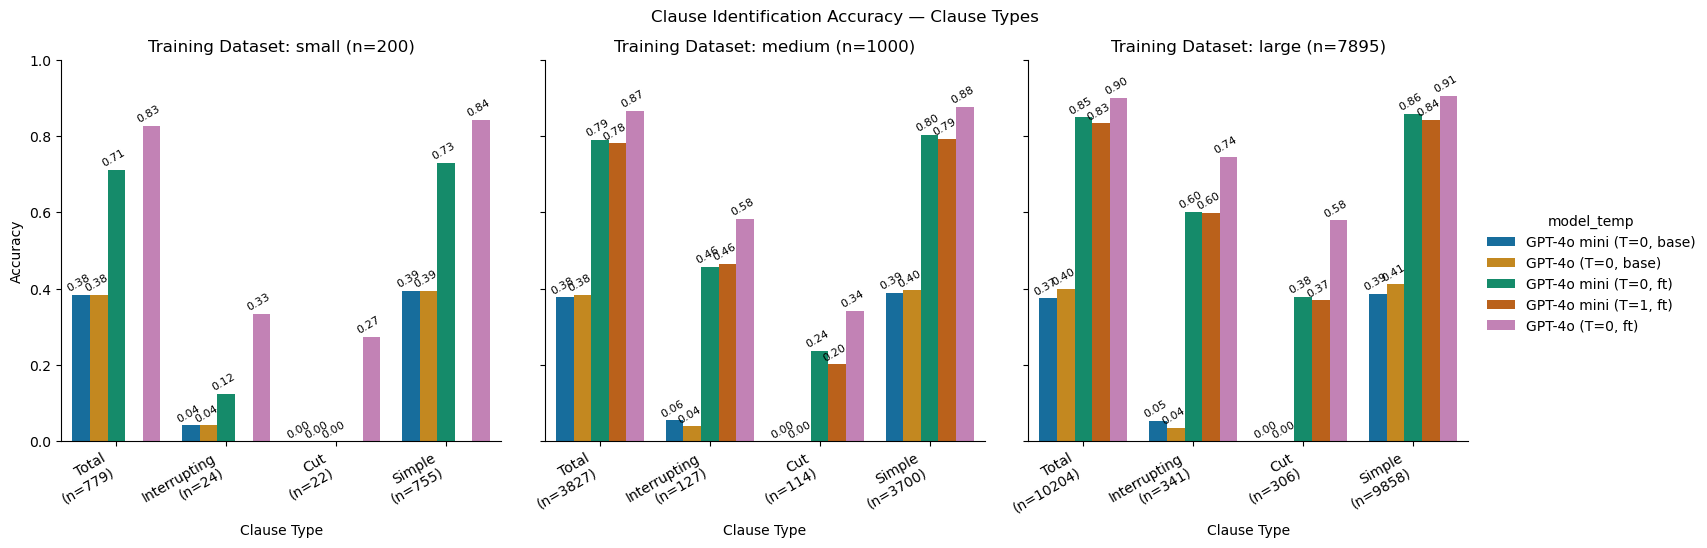

In [72]:
# CLAUSE IDENTIFICATION BASED ON VERSE TYPE
dataset_sizes = {
    "small": 200,
    "medium": 1000,
    "large": 7895,
}

# --- counts per dataset_size (from df_filtered) ---
totals = (
    df_filtered[[
        "dataset_size",
        "total_clauses",
        "total_embedded",
        "total_non_embedded",
        "total_cut_clauses",
    ]]
    .drop_duplicates(subset=["dataset_size"])
    .rename(columns={
        "total_clauses": "Total",
        "total_embedded": "Interrupting",
        "total_non_embedded": "Simple",   # Non-emb ≡ Simple
        "total_cut_clauses": "Cut",
    })
)

n_counts = {
    row["dataset_size"]: {
        "Total": int(row["Total"]),
        "Interrupting": int(row["Interrupting"]),
        "Cut": int(row["Cut"]),
        "Simple": int(row["Simple"]),
    }
    for _, row in totals.iterrows()
}

# --- prepare plot df ---
plot_df = df_filtered[[
    "dataset_size", "model_temp", "acc_total_clauses", "acc_embedded", "acc_non_embedded", "acc_cut"
]]
plot_df_melted = plot_df.melt(
    id_vars=["dataset_size", "model_temp"],
    var_name="Clause Type",
    value_name="Accuracy"
)
plot_df_melted["Clause Type"] = plot_df_melted["Clause Type"].map({
    "acc_total_clauses": "Total",
    "acc_embedded": "Interrupting",
    "acc_non_embedded": "Simple",
    "acc_cut": "Cut",
})

order = ["Total", "Interrupting", "Cut", "Simple"]

# --- plot ---
g = sns.catplot(
    data=plot_df_melted,
    x="Clause Type", y="Accuracy", hue="model_temp",
    col="dataset_size", col_order=["small", "medium", "large"],
    kind="bar", palette="colorblind", height=5, aspect=1,
    order=order, sharex=False, errorbar=None
)

# facet titles include dataset_sizes dict
for ax, ds in zip(g.axes.flat, g.col_names):
    size_n = dataset_sizes.get(ds, "NA")
    ax.set_title(f"Training Dataset: {ds} (n={size_n})")

g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.88, wspace=0.1)
g.fig.suptitle("Clause Identification Accuracy — Clause Types")

# x-tick labels with per-category counts
for ax, ds in zip(g.axes.flat, g.col_names):
    base_labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [f"{lbl}\n(n={n_counts[ds][lbl]})" for lbl in base_labels]
    ax.set_xticklabels(new_labels, rotation=30, ha="right")

# ✅ Add accuracy annotations on top of bars
for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.2f}",    # show with 2 decimal places
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    rotation=30,
                    rotation_mode="anchor"
                )

plt.show()

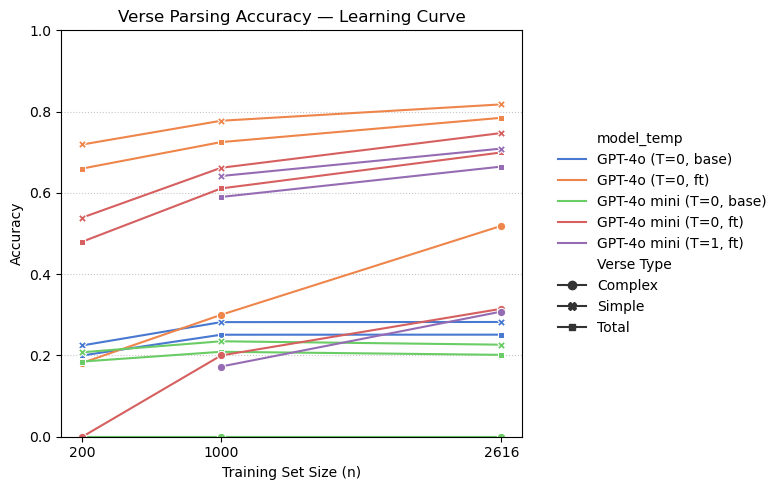

In [89]:
# --- counts per dataset_size (already in your snippet) ---
totals = (
    df_filtered[["dataset_size", "total_simple_verses", "total_complex_verses"]]
    .drop_duplicates(subset=["dataset_size"])
    .rename(columns={"total_simple_verses": "Simple", "total_complex_verses": "Complex"})
    .assign(Total=lambda d: d["Simple"] + d["Complex"])
)
size_map = totals.set_index("dataset_size")["Total"].to_dict()  # {'small': n, 'medium': n, 'large': n}

# --- your existing prep code (unchanged) ---
plot_df = df_filtered[[
    "dataset_size", "model_temp", "acc_total_verses", "acc_simple_verses", "acc_complex_verses"
]]
plot_df_melted = plot_df.melt(
    id_vars=["dataset_size", "model_temp"],
    var_name="Verse Type",
    value_name="Accuracy"
)
plot_df_melted["Verse Type"] = plot_df_melted["Verse Type"].map({
    "acc_total_verses": "Total",
    "acc_simple_verses": "Simple",
    "acc_complex_verses": "Complex"
})

# --- map dataset_size -> numeric N for x-axis (learning curve) ---
plot_df_melted["N_train"] = plot_df_melted["dataset_size"].map(size_map)

# Ensure consistent ordering on the x-axis
order_sizes = ["small", "medium", "large"]
plot_df_melted["dataset_size"] = pd.Categorical(plot_df_melted["dataset_size"], categories=order_sizes, ordered=True)
plot_df_melted = plot_df_melted.sort_values(["dataset_size", "model_temp", "Verse Type"])

# --- line plot: color = model_temp, marker/style = Verse Type ---
plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=plot_df_melted,
    x="N_train", y="Accuracy",
    hue="model_temp",
    style="Verse Type",
    markers=True, dashes=False,
    palette="muted",
    err_style=None
)

# Cosmetics
ax.set_title("Verse Parsing Accuracy — Learning Curve")
ax.set_xlabel("Training Set Size (n)")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)

# Use actual training sizes as ticks
xticks = sorted(plot_df_melted["N_train"].dropna().unique())
ax.set_xticks(xticks)

ax.grid(True, axis="y", linestyle=":", linewidth=0.8, alpha=0.7)

# ✅ Move legend to the right side of the plot
ax.legend(
    title="",
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),   # (x, y) position — 1.05 pushes it to the right
    loc="center left",            # anchor it to the left-center of the legend box
    ncol=1
)

plt.tight_layout()
plt.show()

In [12]:
#g.savefig("figures/clause_type_acc_most_models.png", dpi=300, bbox_inches='tight')

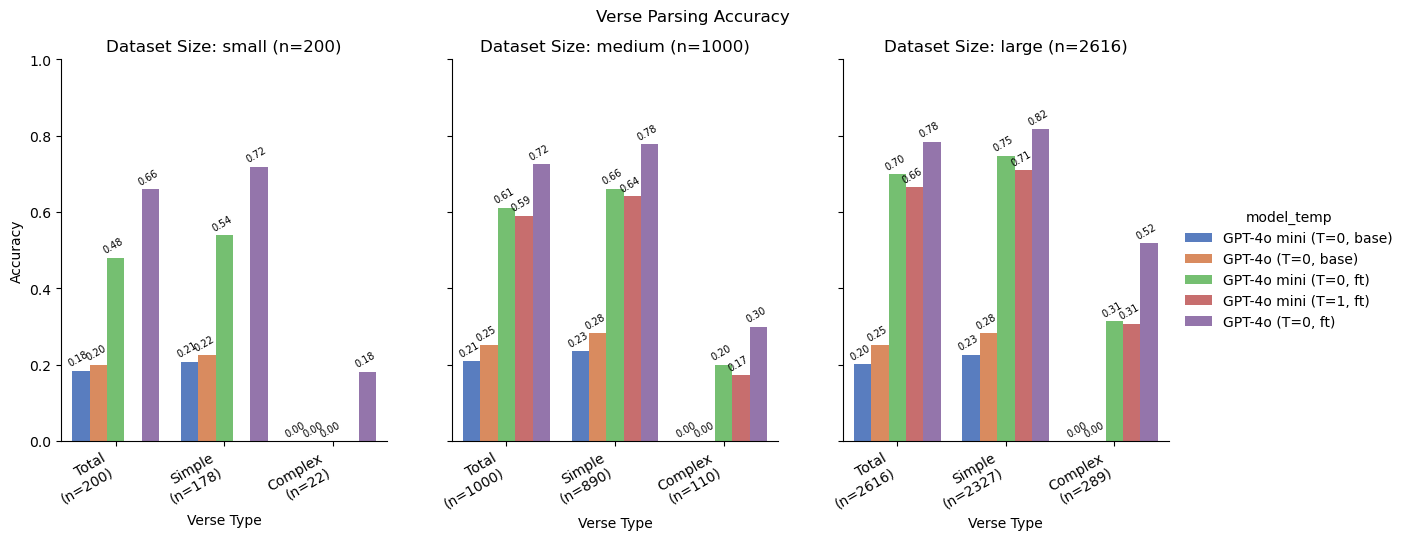

In [83]:
# --- counts per dataset_size ---
totals = (
    df_filtered[["dataset_size", "total_simple_verses", "total_complex_verses"]]
    .drop_duplicates(subset=["dataset_size"])
    .rename(columns={"total_simple_verses": "Simple", "total_complex_verses": "Complex"})
    .assign(Total=lambda d: d["Simple"] + d["Complex"])
)
n_counts = {
    row["dataset_size"]: {
        "Total": int(row["Total"]),
        "Simple": int(row["Simple"]),
        "Complex": int(row["Complex"]),
    }
    for _, row in totals.iterrows()
}

# --- your existing prep code unchanged ---
plot_df = df_filtered[[
    "dataset_size", "model_temp", "acc_total_verses", "acc_simple_verses", "acc_complex_verses"
]]
plot_df_melted = plot_df.melt(
    id_vars=["dataset_size", "model_temp"],
    var_name="Verse Type",
    value_name="Accuracy"
)
plot_df_melted["Verse Type"] = plot_df_melted["Verse Type"].map({
    "acc_total_verses": "Total",
    "acc_simple_verses": "Simple",
    "acc_complex_verses": "Complex"
})

# --- plot ---
x_order = ["Total", "Simple", "Complex"]
g = sns.catplot(
    data=plot_df_melted, x="Verse Type", y="Accuracy", hue="model_temp",
    col="dataset_size", col_order=["small", "medium", "large"],
    kind="bar", palette="muted", height=5, aspect=0.8,
    order=x_order, sharex=False
)
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.88, wspace=0.2)
g.fig.suptitle("Verse Parsing Accuracy")

# ✅ Update titles to include total n
for ax, ds in zip(g.axes.flat, g.col_names):
    total_n = n_counts[ds]["Total"]
    ax.set_title(f"Dataset Size: {ds} (n={total_n})")

# --- per-facet x tick labels with n ---
for ax, ds in zip(g.axes.flat, g.col_names):
    base_labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [f"{lbl}\n(n={n_counts[ds][lbl]})" for lbl in base_labels]
    ax.set_xticklabels(new_labels, rotation=30, ha="right")

# --- bar annotations ---
for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.2f}",
                    ha='center', va='bottom',
                    fontsize=7, rotation=30, rotation_mode='anchor'
                )

plt.show()

In [18]:
#g.savefig("figures/verses_parsing_acc_most_models.png", dpi=300, bbox_inches='tight')

In [84]:
# Analysing fine-tuned models 

df_fine_tuned = df[df["fine_tuned"] == "yes"].copy()
df_fine_tuned["model_temp"] = df_fine_tuned["model"] + " (T=" + df_fine_tuned["temperature"].astype(str) + ")"

In [85]:
# Create accuracy columns
df_fine_tuned["acc_total_clauses"] = df_fine_tuned["total_found"] / df_fine_tuned["total_clauses"]
df_fine_tuned["acc_embedded"] = df_fine_tuned["found_embedded"] / df_fine_tuned["total_embedded"]
df_fine_tuned["acc_non_embedded"] = df_fine_tuned["found_non_embedded"] / df_fine_tuned["total_non_embedded"]
df_fine_tuned["acc_cut"] = df_fine_tuned["found_cut_clauses"] / df_fine_tuned["total_cut_clauses"]
df_fine_tuned["acc_other"] = df_fine_tuned["found_other_clauses"] / df_fine_tuned["total_other_clauses"]

df_fine_tuned["acc_total_verses"] = df_fine_tuned["correct_verses"] / df_fine_tuned["total_verses"]
df_fine_tuned["acc_simple_verses"] = df_fine_tuned["simple_correct"] / df_fine_tuned["total_simple_verses"]
df_fine_tuned["acc_complex_verses"] = df_fine_tuned["complex_correct"] / df_fine_tuned["total_complex_verses"]

In [86]:
#df_fine_tuned.head(5)

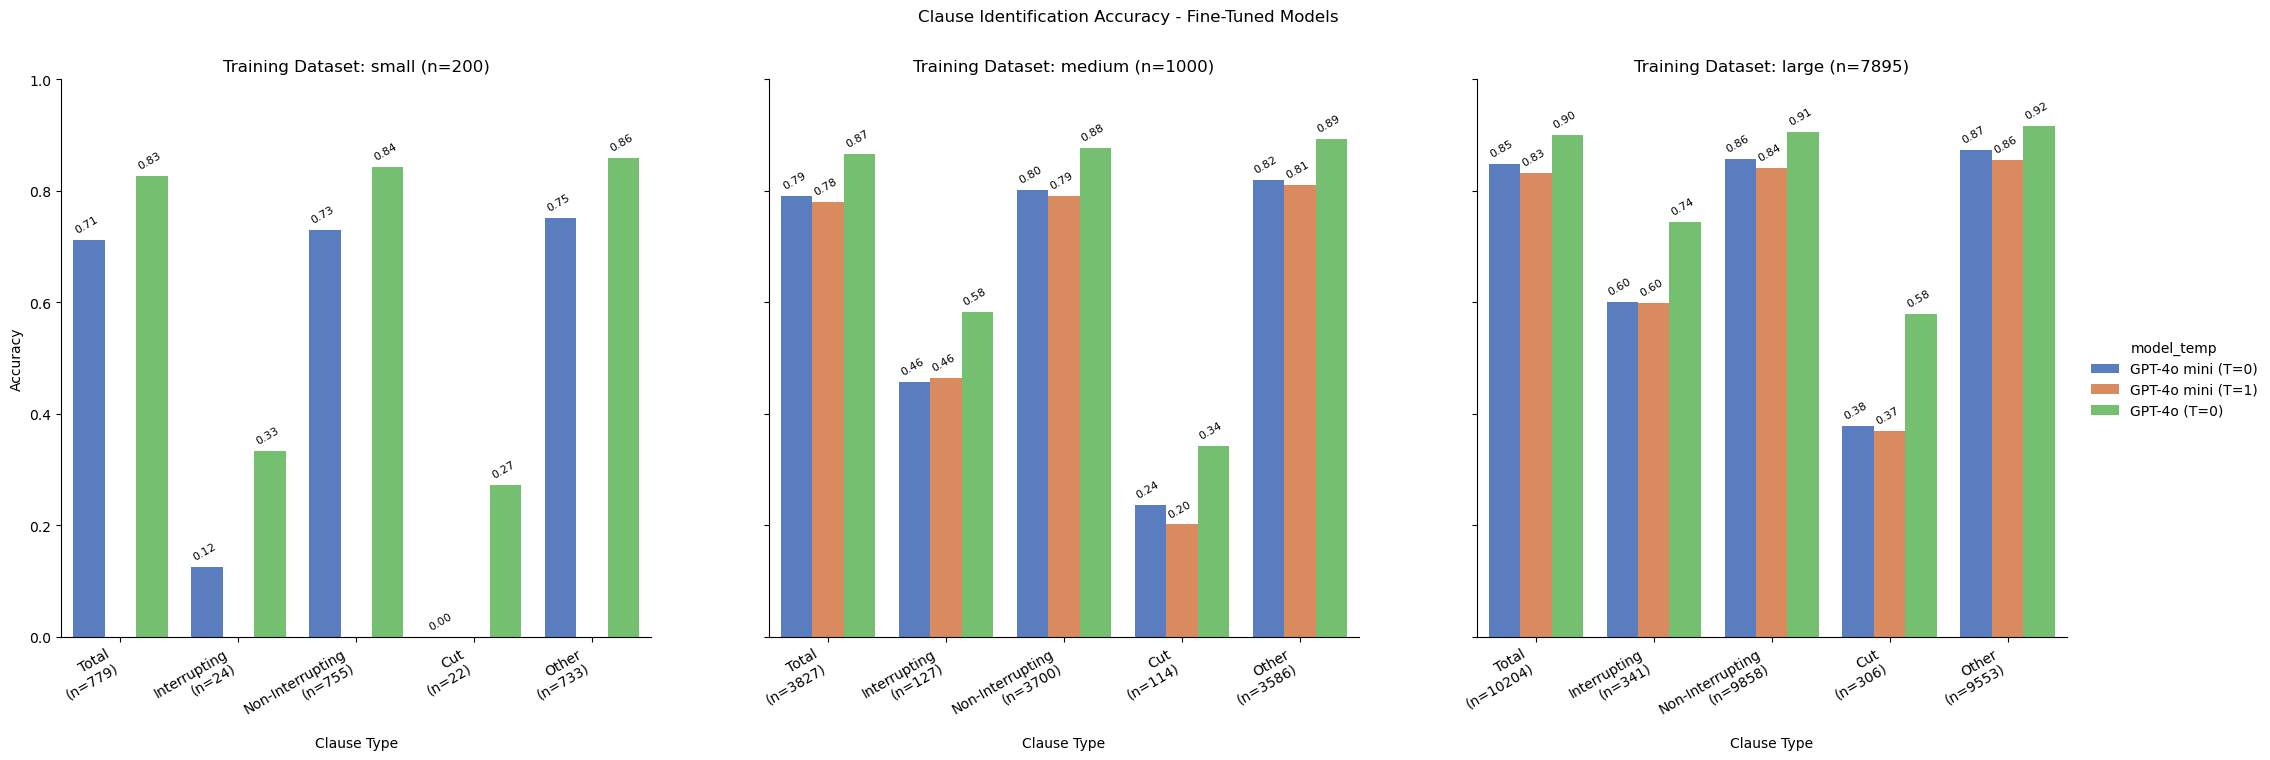

In [87]:
# Dictionary with training dataset sizes
dataset_sizes = {
    "small": 200,
    "medium": 1000,
    "large": 7895,
}

# totals
totals = (
    df_fine_tuned[[
        "dataset_size", 
        "total_clauses",           
        "total_cut_clauses", 
        "total_embedded", 
        "total_non_embedded", 
        "total_other_clauses"
    ]]
    .drop_duplicates(subset=["dataset_size"])
    .rename(columns={
        "total_clauses": "Total",            
        "total_cut_clauses": "Cut",
        "total_embedded": "Interrupting",
        "total_non_embedded": "Non-Interrupting",
        "total_other_clauses": "Other"
    })
)


# n per dataset_size per category
n_counts = {
    row["dataset_size"]: {
        "Total": int(row["Total"]),
        "Interrupting": int(row["Interrupting"]),
        "Non-Interrupting": int(row["Non-Interrupting"]),
        "Cut": int(row["Cut"]),
        "Other": int(row["Other"])
    }
    for _, row in totals.iterrows()
}

# plot data
plot_df = df_fine_tuned[[
    "dataset_size", "model_temp", "acc_total_clauses", "acc_embedded", "acc_non_embedded", "acc_cut", "acc_other"
]]
plot_df_melted = plot_df.melt(
    id_vars=["dataset_size", "model_temp"], 
    var_name="Clause Type", 
    value_name="Accuracy"
)
plot_df_melted["Clause Type"] = plot_df_melted["Clause Type"].map({
    "acc_total_clauses": "Total",
    "acc_embedded": "Interrupting",
    "acc_non_embedded": "Non-Interrupting",
    "acc_cut": "Cut",
    "acc_other": "Other"
})

# catplot
order = ["Total", "Interrupting", "Non-Interrupting", "Cut", "Other"]
g = sns.catplot(
    data=plot_df_melted, x="Clause Type", y="Accuracy", hue="model_temp", 
    col="dataset_size", col_order=["small", "medium", "large"], 
    kind="bar", palette="muted", height=7, aspect=1,
    order=order, sharex=False, errorbar=None  # use ci=None if using seaborn<0.12
)

# facet titles with n from dataset_sizes
for ax, ds in zip(g.axes.flat, g.col_names):
    size_n = dataset_sizes.get(ds, "NA")
    ax.set_title(f"Training Dataset: {ds} (n={size_n})")

# x-axis labels with per-category counts
for ax, ds in zip(g.axes.flat, g.col_names):
    base_labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [
        f"{lbl}\n(n={n_counts[ds][lbl]})" if lbl in n_counts[ds] else lbl
        for lbl in base_labels
    ]
    ax.set_xticklabels(new_labels, rotation=30, ha="right")

# styling + annotations
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.88, wspace=0.2)
g.fig.suptitle("Clause Identification Accuracy - Fine-Tuned Models")

for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.2f}",
                    ha='center', va='bottom', fontsize=8, rotation=30, rotation_mode='anchor'
                )

plt.show()

In [18]:
#g.savefig("figures/clause_identification_acc_fine_tuned_models.png", dpi=300, bbox_inches='tight')

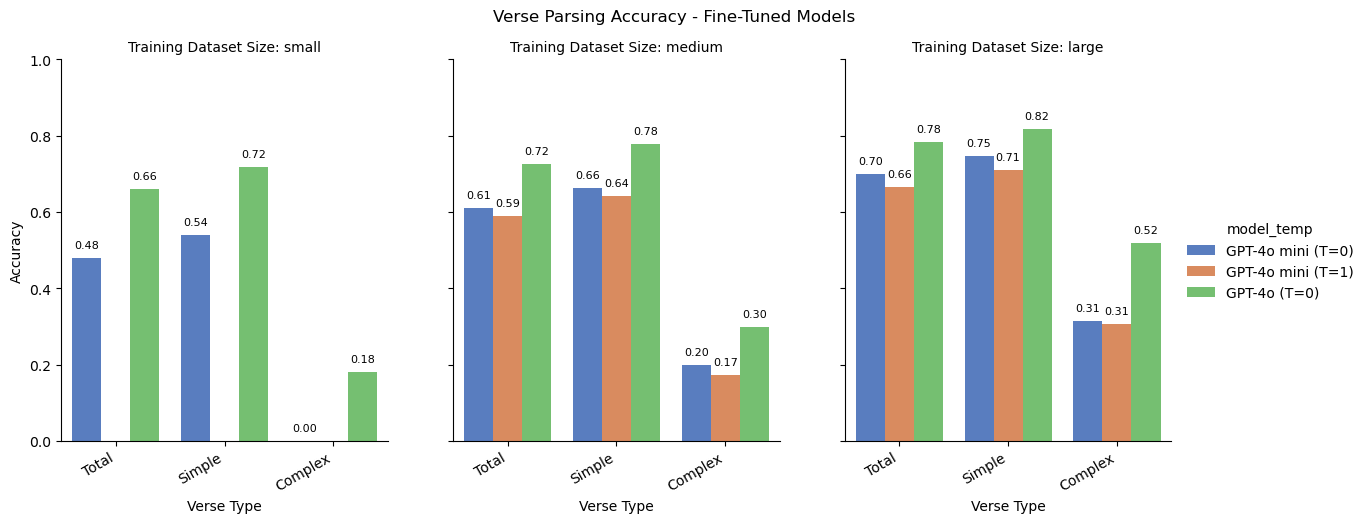

In [23]:
# Accuracy for verses parsing - fined-tuned models
plot_df = df_fine_tuned[[
    "dataset_size", "model_temp", "acc_total_verses", "acc_simple_verses", "acc_complex_verses"
]]
plot_df_melted = plot_df.melt(id_vars=["dataset_size", "model_temp"], 
                              var_name="Verse Type", 
                              value_name="Accuracy")

plot_df_melted["Verse Type"] = plot_df_melted["Verse Type"].map({
    "acc_total_verses": "Total",
    "acc_simple_verses": "Simple",
    "acc_complex_verses": "Complex"
})

# Use facet by dataset size
g = sns.catplot(
    data=plot_df_melted, x="Verse Type", y="Accuracy", hue="model_temp", 
    col="dataset_size", col_order=["small", "medium", "large"], kind="bar", palette="muted", height=5, aspect=0.8 # aspect reduces the bar width
)
g.set_titles("Training Dataset Size: {col_name}")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.85)            

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right") # this rotate the x axis labels

g.fig.subplots_adjust(top=0.88, wspace=0.2) # this reduces the margin and whitespaces

g.fig.suptitle("Verse Parsing Accuracy - Fine-Tuned Models")

for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                   # rotation=30,  # twist
                    rotation_mode='anchor'
                )

plt.show()

In [24]:
#g.savefig("figures/verses_parsing_acc_fine_tuned_models.png", dpi=300, bbox_inches='tight')

In [21]:
# Visualisation for input/output consistency from manual data

In [41]:
df_input_output = pd.read_csv("data/input_output_consistency.csv").fillna("")
df_input_output.columns

Index(['model', 'temperature', 'fine_tuned', 'training_dataset_size',
       'percentage_exact_restitution', 'percentage_exact_words_restitution'],
      dtype='object')

In [42]:
df_input_output = df_input_output.copy()
df_input_output["model_temp"] = (
    df_input_output["model"] + 
    " (T=" + df_input_output["temperature"].astype(str) + 
    ", " + df_input_output["fine_tuned"].map({"yes": "ft", "no": "base"}) + ")"
)

In [60]:
df_input_output.head()

,model,temperature,fine_tuned,training_dataset_size,percentage_exact_restitution,percentage_exact_words_restitution,model_temp
0,GPT-4o,0,yes,small,94.500000,99.00000,"GPT-4o (T=0, ft)"
1,GPT-4o,0,yes,medium,92.300000,99.20000,"GPT-4o (T=0, ft)"
2,GPT-4o,0,yes,large,89.067278,98.96789,"GPT-4o (T=0, ft)"
3,GPT-4o mini,0,yes,small,95.000000,99.00000,"GPT-4o mini (T=0, ft)"
4,GPT-4o mini,0,yes,medium,94.400000,98.90000,"GPT-4o mini (T=0, ft)"


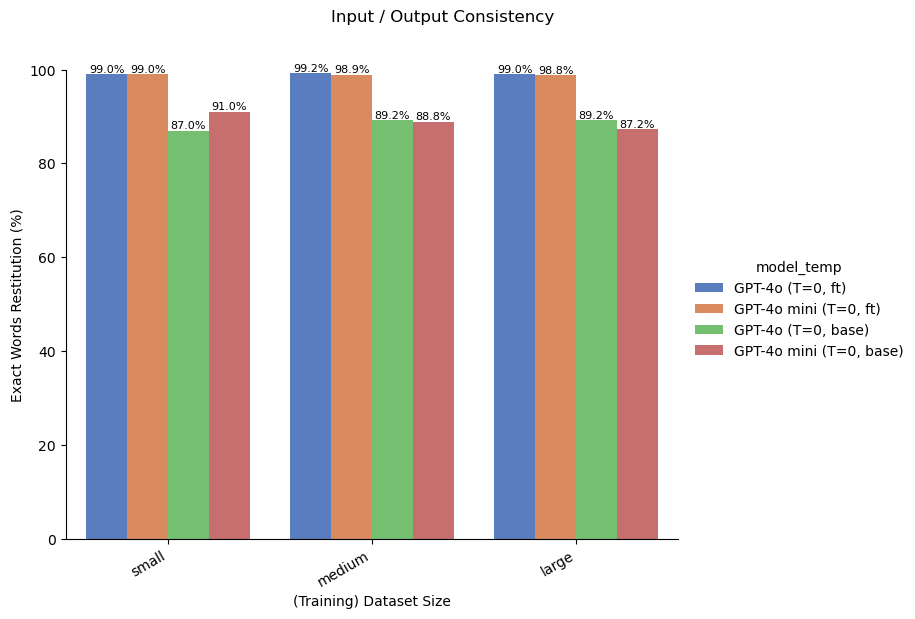

In [44]:
# Prepare data for plotting

# Dictionary with dataset sizes

dataset_sizes = {
    "small": 200,
    "medium": 1000,
    "large": 2616,
}

# Prepare the data with only one metric
plot_df = df_input_output[[
    "training_dataset_size", "model_temp", "percentage_exact_words_restitution"
]]

# Use catplot for easy faceting and .axes.flat access
g = sns.catplot(
    data=plot_df,
    x="training_dataset_size",
    y="percentage_exact_words_restitution",
    hue="model_temp",
    kind="bar",
    palette="muted",
    height=6,
    aspect=1.2
)

# Set general appearance
g.set_axis_labels("(Training) Dataset Size", "Exact Words Restitution (%)")
g.set(ylim=(0, 100))
g.fig.subplots_adjust(top=0.88, right=0.75)  # Adjust top + leave space on right for legend
g.fig.suptitle("Input / Output Consistency")

# Rotate x-axis labels and add value labels on bars
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f"{height:.1f}%",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    rotation_mode='anchor'
                )

plt.show()

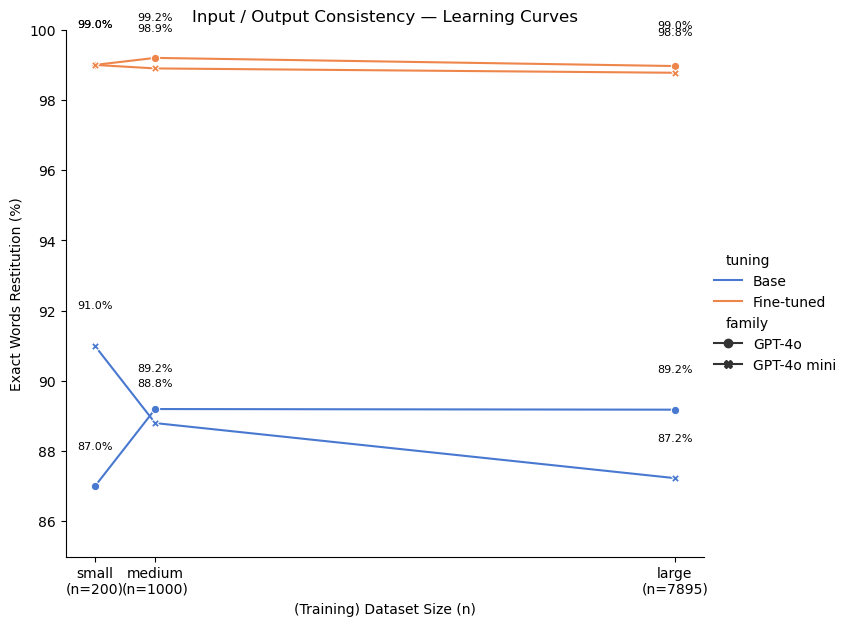

In [94]:
# Dictionary with dataset sizes
dataset_sizes = {
    "small": 200,
    "medium": 1000,
    "large": 7895,
}

# Prepare the data with only one metric
plot_df = df_input_output[[
    "training_dataset_size", "model_temp", "percentage_exact_words_restitution"
]].copy()

# Map training size to numeric n for a true learning curve
plot_df["n_train"] = plot_df["training_dataset_size"].map(dataset_sizes)

# Derive two factors: tuning state (Base vs Fine-tuned) and model family (GPT-4o vs GPT-4o mini)
plot_df["tuning"] = plot_df["model_temp"].str.contains(r"\bft\b").map({True: "Fine-tuned", False: "Base"})
plot_df["family"] = plot_df["model_temp"].str.extract(r"^(GPT-4o(?: mini)?)")

# If there are multiple runs per cell, average them for a clean curve
agg = (plot_df
       .groupby(["n_train", "training_dataset_size", "tuning", "family"], as_index=False)
       .agg(percentage_exact_words_restitution=("percentage_exact_words_restitution", "mean")))

# Order x explicitly
x_order = [dataset_sizes[k] for k in ["small", "medium", "large"]]
agg = agg.sort_values(by="n_train")

# Line plot: color = tuning (Base vs Fine-tuned), style/marker = family (GPT-4o vs GPT-4o mini)
g = sns.relplot(
    data=agg,
    kind="line",
    x="n_train",
    y="percentage_exact_words_restitution",
    hue="tuning",            # color encodes base vs ft
    style="family",          # line/marker encodes model family
    markers=True,
    dashes=False,
    palette="muted",
    height=6,
    aspect=1.2,
    errorbar=None            
)

ax = g.axes.flat[0]
ax.set_xlabel("(Training) Dataset Size (n)")
ax.set_ylabel("Exact Words Restitution (%)")
ax.set_title("Input / Output Consistency — Learning Curves")

# Nice x-ticks showing size categories and n
ax.set_xticks(x_order)
ax.set_xticklabels([f"small\n(n={dataset_sizes['small']})",
                    f"medium\n(n={dataset_sizes['medium']})",
                    f"large\n(n={dataset_sizes['large']})"])

ax.set_ylim(85, 100)

# Optional: annotate each point with its % value
for _, r in agg.iterrows():
    ax.text(
        r["n_train"],
        r["percentage_exact_words_restitution"] + 1.0,
        f"{r['percentage_exact_words_restitution']:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.show()

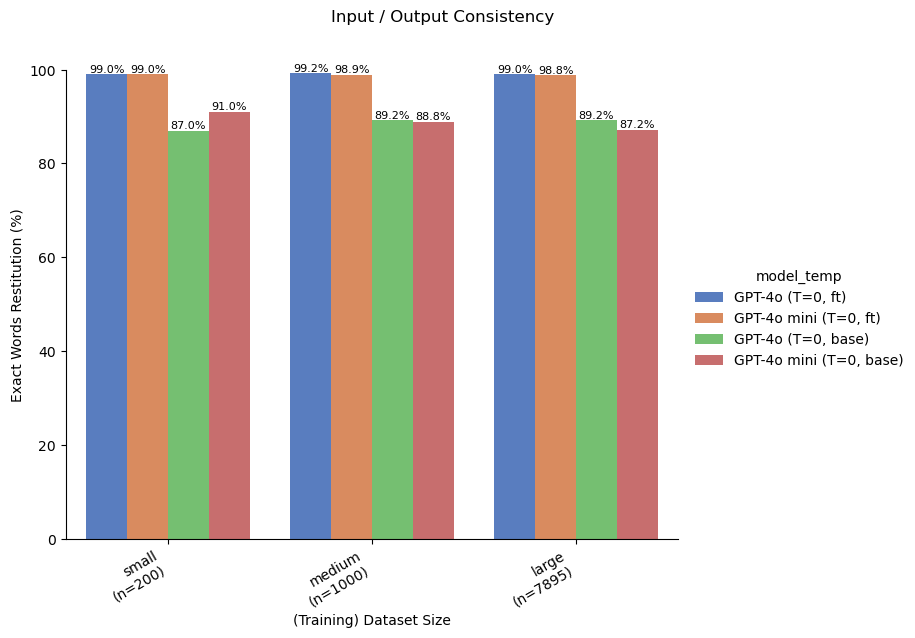

In [47]:
# Dictionary with dataset sizes
dataset_sizes = {
    "small": 200,
    "medium": 1000,
    "large": 7895,
}

# Prepare the data with only one metric
plot_df = df_input_output[[
    "training_dataset_size", "model_temp", "percentage_exact_words_restitution"
]]

# Plot (lock order; optionally remove CIs with ci=None)
g = sns.catplot(
    data=plot_df,
    x="training_dataset_size",
    y="percentage_exact_words_restitution",
    hue="model_temp",
    kind="bar",
    palette="muted",
    height=6,
    aspect=1.2,
    order=["small", "medium", "large"],
    errorbar=None  # remove error bars; delete this if you want CIs
)

# Labels, limits, title
g.set_axis_labels("(Training) Dataset Size", "Exact Words Restitution (%)")
g.set(ylim=(0, 100))
g.fig.subplots_adjust(top=0.88, right=0.75)
g.fig.suptitle("Input / Output Consistency")

# Replace x-tick labels with counts (n=...)
ax = g.axes.flat[0]
base_labels = [t.get_text() for t in ax.get_xticklabels()]
new_labels = [
    f"{lbl}\n(n={dataset_sizes.get(lbl, 'NA')})"  # falls back to 'NA' if unexpected label
    for lbl in base_labels
]
ax.set_xticklabels(new_labels, rotation=30, ha="right")

# Value labels on bars (unchanged)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.02,
                f"{height:.1f}%",
                ha='center',
                va='bottom',
                fontsize=8,
                rotation_mode='anchor'
            )

plt.show()

In [39]:
#g.savefig("figures/input_output_consistency_by_model_and_size_words.png", dpi=300, bbox_inches='tight')